In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

In [2]:
sns.set(style="darkgrid")

In [3]:
df_app_raw = pd.read_csv("./loan_defaulter/application_data.csv")
df_previous_raw = pd.read_csv("./loan_defaulter/previous_application.csv")
df_info = pd.read_csv("./loan_defaulter/columns_description.csv")

In [4]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 150)
pd.set_option('display.width', 800)
pd.set_option('display.expand_frame_repr', False)

In [5]:
df_info.drop(columns=["Unnamed: 0"], inplace=True)

- Cek 1 user berkali2 pinjam atau tidak.
- Handling missing value dengan MAR (cek keterkaitan)
- Langkah penanganan loan terprediksi default
- Cari referensi penanganan nasabah pinjaman default

In [186]:
df_info[df_info["Table"] == "application_data"].head()

,Table,Row,Description,Special
0,application_data,SK_ID_CURR,ID of loan in our sample,NaN
1,application_data,TARGET,Target variable (1 - client with payment diffi...,NaN
2,application_data,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,application_data,CODE_GENDER,Gender of the client,NaN
4,application_data,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [7]:
df_app_raw.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [8]:
df_previous_raw.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Database dimension
print("Application: ",df_app_raw.shape)
print("Previous Application:",df_previous_raw.shape)

Application:  (307511, 122)
Previous Application: (1670214, 37)


In [10]:
df_app_raw.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

In [11]:
df_previous_raw.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [12]:
df_app_raw.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97

In [13]:
df_previous_raw.describe()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,774370.000000,5951.000000,5951.000000,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,1.923089e+06,2.783572e+05,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,1.248418e+01,9.964675e-01,0.079637,0.188357,0.773503,-8.806797e+02,3.139511e+02,1.605408e+01,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,3.334028e+00,5.932963e-02,0.107823,0.087671,0.100879,7.790997e+02,7.127443e+03,1.456729e+01,88916.115833,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-0.000015,0.034781,0.373150,-2.922000e+03,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,1.000000e+01,1.000000e+00,0.000000,0.160716,0.715645,-1.300000e+03,-1.000000e+00,6.000000e+00,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,1.200000e+01,1.000000e+00,0.051605,0.189122,0.835095,-5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.500000e+01,1.000000e+00,0.108909,0.193330,0.852537,-2.800000e+02,8.200000e+01,2.400000e+01,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000
max,2.845382e+06,4.562550e+05,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.300000e+01,1.000000e+00,1.000000,1.000000,1.000000,-1.000000e+00,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


With this many data features, I wouldn't be able to make a decent analysis in a tight schedule. For this current version of analysis, columns with more than 40% of missing value are dropped.

In [15]:
round(df_app_raw.isnull().sum() / df_app_raw.shape[0] *100, 2)

SK_ID_CURR                       0.00
TARGET                           0.00
NAME_CONTRACT_TYPE               0.00
CODE_GENDER                      0.00
FLAG_OWN_CAR                     0.00
FLAG_OWN_REALTY                  0.00
CNT_CHILDREN                     0.00
AMT_INCOME_TOTAL                 0.00
AMT_CREDIT                       0.00
AMT_ANNUITY                      0.00
AMT_GOODS_PRICE                  0.09
NAME_TYPE_SUITE                  0.42
NAME_INCOME_TYPE                 0.00
NAME_EDUCATION_TYPE              0.00
NAME_FAMILY_STATUS               0.00
NAME_HOUSING_TYPE                0.00
REGION_POPULATION_RELATIVE       0.00
DAYS_BIRTH                       0.00
DAYS_EMPLOYED                    0.00
DAYS_REGISTRATION                0.00
DAYS_ID_PUBLISH                  0.00
OWN_CAR_AGE                     65.99
FLAG_MOBIL                       0.00
FLAG_EMP_PHONE                   0.00
FLAG_WORK_PHONE                  0.00
FLAG_CONT_MOBILE                 0.00
FLAG_PHONE  

In [16]:
round(df_previous_raw.isnull().sum() / df_previous_raw.shape[0] *100, 2)

SK_ID_PREV                      0.00
SK_ID_CURR                      0.00
NAME_CONTRACT_TYPE              0.00
AMT_ANNUITY                    22.29
AMT_APPLICATION                 0.00
AMT_CREDIT                      0.00
AMT_DOWN_PAYMENT               53.64
AMT_GOODS_PRICE                23.08
WEEKDAY_APPR_PROCESS_START      0.00
HOUR_APPR_PROCESS_START         0.00
FLAG_LAST_APPL_PER_CONTRACT     0.00
NFLAG_LAST_APPL_IN_DAY          0.00
RATE_DOWN_PAYMENT              53.64
RATE_INTEREST_PRIMARY          99.64
RATE_INTEREST_PRIVILEGED       99.64
NAME_CASH_LOAN_PURPOSE          0.00
NAME_CONTRACT_STATUS            0.00
DAYS_DECISION                   0.00
NAME_PAYMENT_TYPE               0.00
CODE_REJECT_REASON              0.00
NAME_TYPE_SUITE                49.12
NAME_CLIENT_TYPE                0.00
NAME_GOODS_CATEGORY             0.00
NAME_PORTFOLIO                  0.00
NAME_PRODUCT_TYPE               0.00
CHANNEL_TYPE                    0.00
SELLERPLACE_AREA                0.00
N

In [17]:
df_app = df_app_raw.copy()
df_previous = df_previous_raw.copy()

In [18]:
app_columns = pd.DataFrame(
    data={
        "column_name": df_app.columns,
        "null_percent": round(df_app.isnull().sum() / df_app.shape[0] * 100, 2).values,
    }
)

previous_columns = pd.DataFrame(
    data={
        "column_name": df_previous.columns,
        "null_percent": round(
            df_previous.isnull().sum() / df_previous.shape[0] * 100, 2
        ).values,
    }
)

C:\Users\AHMAD\AppData\Local\Temp\ipykernel_17452\214880069.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


<function matplotlib.pyplot.show(close=None, block=None)>

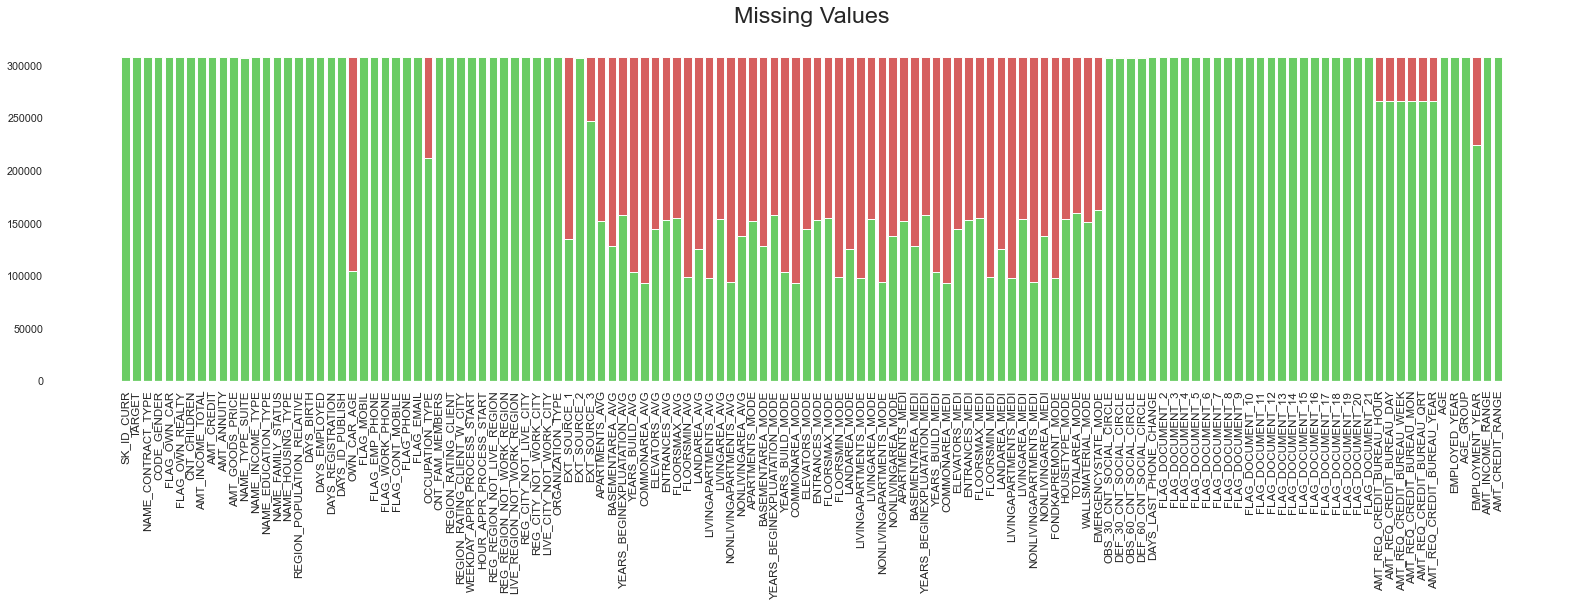

In [192]:
# Check missing value
missing_count = df_app.isna().sum()
non_missing = df_app.notnull().sum()

# Visualize missing value
x = df_app.columns
fig, ax = plt.subplots(figsize=(28, 6), dpi=70)
ax.set_facecolor("white")
ax.bar(x, missing_count, color="#d65f5f", bottom=non_missing)
ax.bar(x, non_missing, color="#6acc64")
# for i, j in enumerate(missing_count):
#     plt.text(i, 795000, str(j), ha='center', va='center', color='black')
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    ha="center",
    **{"font": "Arial", "weight": "normal"},
    alpha=1
)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.title(label="Missing Values", fontdict={'fontsize': 24, 'font': 'Arial'}, pad=36)
plt.show

In [19]:
app_columns[app_columns.null_percent > 40].head(10)

,column_name,null_percent
21,OWN_CAR_AGE,65.99
41,EXT_SOURCE_1,56.38
44,APARTMENTS_AVG,50.75
45,BASEMENTAREA_AVG,58.52
46,YEARS_BEGINEXPLUATATION_AVG,48.78
47,YEARS_BUILD_AVG,66.50
48,COMMONAREA_AVG,69.87
49,ELEVATORS_AVG,53.30
50,ENTRANCES_AVG,50.35
51,FLOORSMAX_AVG,49.76


In [20]:
app_columns_high_missing = app_columns[app_columns.null_percent > 40]["column_name"].values
app_columns_high_missing

array(['OWN_CAR_AGE', 'EXT_SOURCE_1', 'APARTMENTS_AVG',
       'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG',
       'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE',
       'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
       'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE',
       'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI',
       'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI',
       'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
       'NONLIVINGAPARTMENTS_MEDI', 'NON

In [21]:
previous_columns[previous_columns.null_percent > 40].head(10)

,column_name,null_percent
6,AMT_DOWN_PAYMENT,53.64
12,RATE_DOWN_PAYMENT,53.64
13,RATE_INTEREST_PRIMARY,99.64
14,RATE_INTEREST_PRIVILEGED,99.64
20,NAME_TYPE_SUITE,49.12
31,DAYS_FIRST_DRAWING,40.30
32,DAYS_FIRST_DUE,40.30
33,DAYS_LAST_DUE_1ST_VERSION,40.30
34,DAYS_LAST_DUE,40.30
35,DAYS_TERMINATION,40.30


In [22]:
previous_columns_high_missing = previous_columns[previous_columns.null_percent > 40]["column_name"].values
previous_columns_high_missing

array(['AMT_DOWN_PAYMENT', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_TYPE_SUITE',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION',
       'NFLAG_INSURED_ON_APPROVAL'], dtype=object)

In [25]:
df_app.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [26]:
df_previous.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


Mutate days column into years.

In [27]:
df_app[['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH']]

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH
0,-9461,-637,-3648.0,-2120
1,-16765,-1188,-1186.0,-291
2,-19046,-225,-4260.0,-2531
3,-19005,-3039,-9833.0,-2437
4,-19932,-3038,-4311.0,-3458
...,...,...,...,...
307506,-9327,-236,-8456.0,-1982
307507,-20775,365243,-4388.0,-4090
307508,-14966,-7921,-6737.0,-5150
307509,-11961,-4786,-2562.0,-931


In [28]:
for col in ['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH']:
    df_app[col] = abs(df_app[col])

Since no days column left in previous dataframe, there will be no need to mutate the columns.

In [29]:
df_app["AGE"] = df_app["DAYS_BIRTH"] //365
df_app["EMPLOYED_YEAR"] = df_app["DAYS_EMPLOYED"] //365

Check for categorical columns with unique values count.

In [30]:
df_app.nunique().sort_values(ascending=False)

SK_ID_CURR                      307511
EXT_SOURCE_2                    119831
EXT_SOURCE_1                    114584
DAYS_BIRTH                       17460
DAYS_REGISTRATION                15688
AMT_ANNUITY                      13672
DAYS_EMPLOYED                    12574
DAYS_ID_PUBLISH                   6168
AMT_CREDIT                        5603
LIVINGAREA_MODE                   5301
LIVINGAREA_MEDI                   5281
LIVINGAREA_AVG                    5199
TOTALAREA_MODE                    5116
BASEMENTAREA_MODE                 3841
BASEMENTAREA_AVG                  3780
DAYS_LAST_PHONE_CHANGE            3773
BASEMENTAREA_MEDI                 3772
LANDAREA_MODE                     3563
LANDAREA_MEDI                     3560
LANDAREA_AVG                      3527
NONLIVINGAREA_MODE                3327
NONLIVINGAREA_MEDI                3323
NONLIVINGAREA_AVG                 3290
COMMONAREA_MEDI                   3202
COMMONAREA_AVG                    3181
COMMONAREA_MODE          

In [31]:
df_app.select_dtypes(include="bool").columns

Index([], dtype='object')

In [32]:
obj_cols = df_app.select_dtypes(include="object").columns.to_list()
obj_cols

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [33]:
df_app[obj_cols].nunique().sort_values(ascending=False)

ORGANIZATION_TYPE             58
OCCUPATION_TYPE               18
NAME_INCOME_TYPE               8
NAME_TYPE_SUITE                7
WEEKDAY_APPR_PROCESS_START     7
WALLSMATERIAL_MODE             7
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_EDUCATION_TYPE            5
FONDKAPREMONT_MODE             4
CODE_GENDER                    3
HOUSETYPE_MODE                 3
NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
EMERGENCYSTATE_MODE            2
dtype: int64

We can safely say that object columns are categorical. There are also numerical columns with few unique values. We will assume columns with unique value fewer than 9 is a categorical columns.

To get categorical columns, I created a function returning a list for the columns.

In [34]:
df_app.nunique().sort_values(ascending=False).reset_index().rename(columns={"index": "column", 0: "unique_count"})["unique_count"]
    # return np.array(list(set(obj_cols + unique_cols)))

0      307511
1      119831
2      114584
3       17460
4       15688
5       13672
6       12574
7        6168
8        5603
9        5301
10       5281
11       5199
12       5116
13       3841
14       3780
15       3773
16       3772
17       3563
18       3560
19       3527
20       3327
21       3323
22       3290
23       3202
24       3181
25       3128
26       2548
27       2339
28       1868
29       1148
30       1097
31       1002
32        814
33        760
34        736
35        403
36        386
37        305
38        285
39        285
40        257
41        245
42        221
43        214
44        167
45        154
46        151
47        149
48         81
49         62
50         58
51         51
52         50
53         49
54         47
55         46
56         46
57         33
58         33
59         30
60         26
61         25
62         25
63         25
64         24
65         24
66         18
67         17
68         15
69         11
70         10
71    

In [35]:
def categorical_columns(df):
    obj_cols = df.select_dtypes(include="object").columns.to_list()
    unique_value = (
        df.nunique()
        .sort_values(ascending=False)
        .reset_index()
        .rename(columns={"index": "column", 0: "unique_count"})
    )
    unique_cols = unique_value[unique_value["unique_count"] < 9]["column"].to_list()
    return np.array(list(set(obj_cols + unique_cols)))
    

In [36]:
app_cat_cols = categorical_columns(df_app)

In [37]:
app_cat_cols

array(['FLAG_DOCUMENT_4', 'NAME_CONTRACT_TYPE', 'FLAG_DOCUMENT_16',
       'FLAG_EMAIL', 'REGION_RATING_CLIENT_W_CITY', 'FLAG_DOCUMENT_13',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_21', 'NAME_INCOME_TYPE',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_17',
       'REG_REGION_NOT_LIVE_REGION', 'WALLSMATERIAL_MODE',
       'REG_CITY_NOT_LIVE_CITY', 'FONDKAPREMONT_MODE', 'TARGET',
       'LIVE_CITY_NOT_WORK_CITY', 'CODE_GENDER', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_14', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'LIVE_REGION_NOT_WORK_REGION',
       'FLAG_DOCUMENT_7', 'REGION_RATING_CLIENT', 'FLAG_DOCUMENT_10',
       'NAME_EDUCATION_TYPE', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'NAME_FAMILY_STATUS',
       'WEEKDAY_APPR_PROCESS_START', 'FLAG_DOCUMENT_11',
       'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE',
       'FLAG_OWN_CAR', 'FLAG_MOBIL', 'FLAG_

In [38]:
prev_cat_cols = categorical_columns(df_previous)

In [39]:
app_cat_cols[~np.isin(app_cat_cols, prev_cat_cols)]


array(['FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_16', 'FLAG_EMAIL',
       'REGION_RATING_CLIENT_W_CITY', 'FLAG_DOCUMENT_13',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_21', 'NAME_INCOME_TYPE',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_17',
       'REG_REGION_NOT_LIVE_REGION', 'WALLSMATERIAL_MODE',
       'REG_CITY_NOT_LIVE_CITY', 'FONDKAPREMONT_MODE', 'TARGET',
       'LIVE_CITY_NOT_WORK_CITY', 'CODE_GENDER', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_14', 'FLAG_OWN_REALTY',
       'LIVE_REGION_NOT_WORK_REGION', 'FLAG_DOCUMENT_7',
       'REGION_RATING_CLIENT', 'FLAG_DOCUMENT_10', 'NAME_EDUCATION_TYPE',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'HOUSETYPE_MODE',
       'EMERGENCYSTATE_MODE', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'NAME_FAMILY_STATUS', 'FLAG_DOCUMENT_11', 'OCCUPATION_TYPE',
       'REG_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'FLAG_OWN_CAR',
       'FLAG_MOBIL', 'FLAG_DOCUMENT_12', 'REG_REGION_NOT_WORK_REGION',
       'FLAG_DOCUMENT_2', 'FLAG_CO

Only organization_type and occupation_type columns not found in previous data.

Let's check if the ID from previous applications match the application datasets. 

In [40]:
df_previous["SK_ID_CURR"].unique()

array([271877, 108129, 122040, ..., 253940, 353284, 191629], dtype=int64)

<div class="alert alert-block alert-success">
    <span style='font-family:Georgia'>
        <b>Decisive Factor whether an applicant will be Repayer: </b> 
        <ol>
            <li>NAME_EDUCATION_TYPE: Academic degree has less defaults. </li>
            <li>NAME_INCOME_TYPE: Student and Businessmen have no defaults.</li>
            <li>REGION_RATING_CLIENT: RATING 1 is safer.</li>
            <li>ORGANIZATION_TYPE: Clients with Trade Type 4 and 5 and Industry type 8 have defaulted less than 3%</li>
            <li>DAYS_BIRTH: People above age of 50 have low probability of defaulting</li>
            <li>DAYS_EMPLOYED: Clients with 40+ year experience having less than 1% default rate</li>
            <li>AMT_INCOME_TOTAL:Applicant with Income more than 700,000 are less likely to default</li>
            <li>NAME_CASH_LOAN_PURPOSE: Loans bought for Hobby, Buying garage are being repayed mostly.</li>
            <li>CNT_CHILDREN: People with zero to two children tend to repay the loans.</li>
        </ol>
    </span>    
</div>

In [41]:
df_app.shape

(307511, 124)

In [42]:
df_app["SK_ID_CURR"].isin(df_previous["SK_ID_CURR"].unique()).sum()

291057

In [43]:
df_previous["SK_ID_CURR"].isin(df_app["SK_ID_CURR"].unique()).sum()

1413701

`There are 291057 borrowers who have repeatedly asked for loans, and some borrowers have requested loan more than once given the same ID have more occurence in previous dataset.`

In [44]:
target_id = df_app[["SK_ID_CURR", "TARGET"]]

In [45]:
df_previous = df_previous.merge(target_id, how='left', on='SK_ID_CURR')

## Check relevance with the default status.

In [46]:
df_app[["EXT_SOURCE_1", "EXT_SOURCE_2","EXT_SOURCE_3","TARGET"]]

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TARGET
0,0.083037,0.262949,0.139376,1
1,0.311267,0.622246,NaN,0
2,NaN,0.555912,0.729567,0
3,NaN,0.650442,NaN,0
4,NaN,0.322738,NaN,0
...,...,...,...,...
307506,0.145570,0.681632,NaN,0
307507,NaN,0.115992,NaN,0
307508,0.744026,0.535722,0.218859,0
307509,NaN,0.514163,0.661024,1


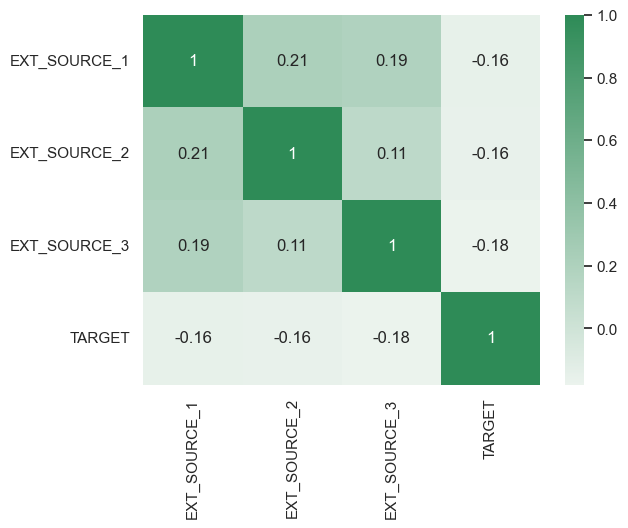

In [47]:
# Checking correlation of EXT_SOURCE_X columns vs TARGET column
source_corr = df_app[["EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3","TARGET"]].corr()
ax = sns.heatmap(source_corr,
            xticklabels=source_corr.columns,
            yticklabels=source_corr.columns,
            annot = True,
            cmap =sns.light_palette("seagreen", as_cmap=True))

Ext_source is not important.

C:\Users\AHMAD\AppData\Local\Temp\ipykernel_17452\2751039927.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flag["TARGET"] = df_flag["TARGET"].replace({1: "Defaulter", 0: "Repayer"})


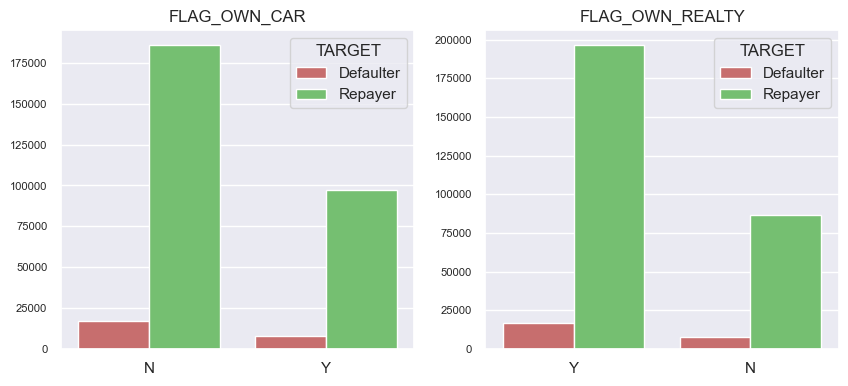

In [48]:
# Checking the relevance of Flag_Document and whether it has any relation with loan repayment status
document_columns = [
    "FLAG_OWN_CAR",
    "FLAG_OWN_REALTY"
]
df_flag = df_app[document_columns + ["TARGET"]]

length = len(document_columns)

df_flag["TARGET"] = df_flag["TARGET"].replace({1: "Defaulter", 0: "Repayer"})

fig = plt.figure(figsize=(21, 24))

for i, j in itertools.zip_longest(document_columns, range(length)):
    plt.subplot(5, 4, j + 1)
    # ax = df_flag[i].value_counts.plot(kind="bar", stacked=True, color=["#d65f5f","#6acc64"])
    ax = sns.countplot(
        data=df_flag,
        x=i,
        hue=df_flag["TARGET"],
        palette=["#d65f5f","#6acc64"],
    )
    plt.yticks(fontsize=8)
    plt.xlabel("")
    plt.ylabel("")
    plt.title(i)

C:\Users\AHMAD\AppData\Local\Temp\ipykernel_17452\622011494.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flag["TARGET"] = df_flag["TARGET"].replace({1: "Defaulter", 0: "Repayer"})


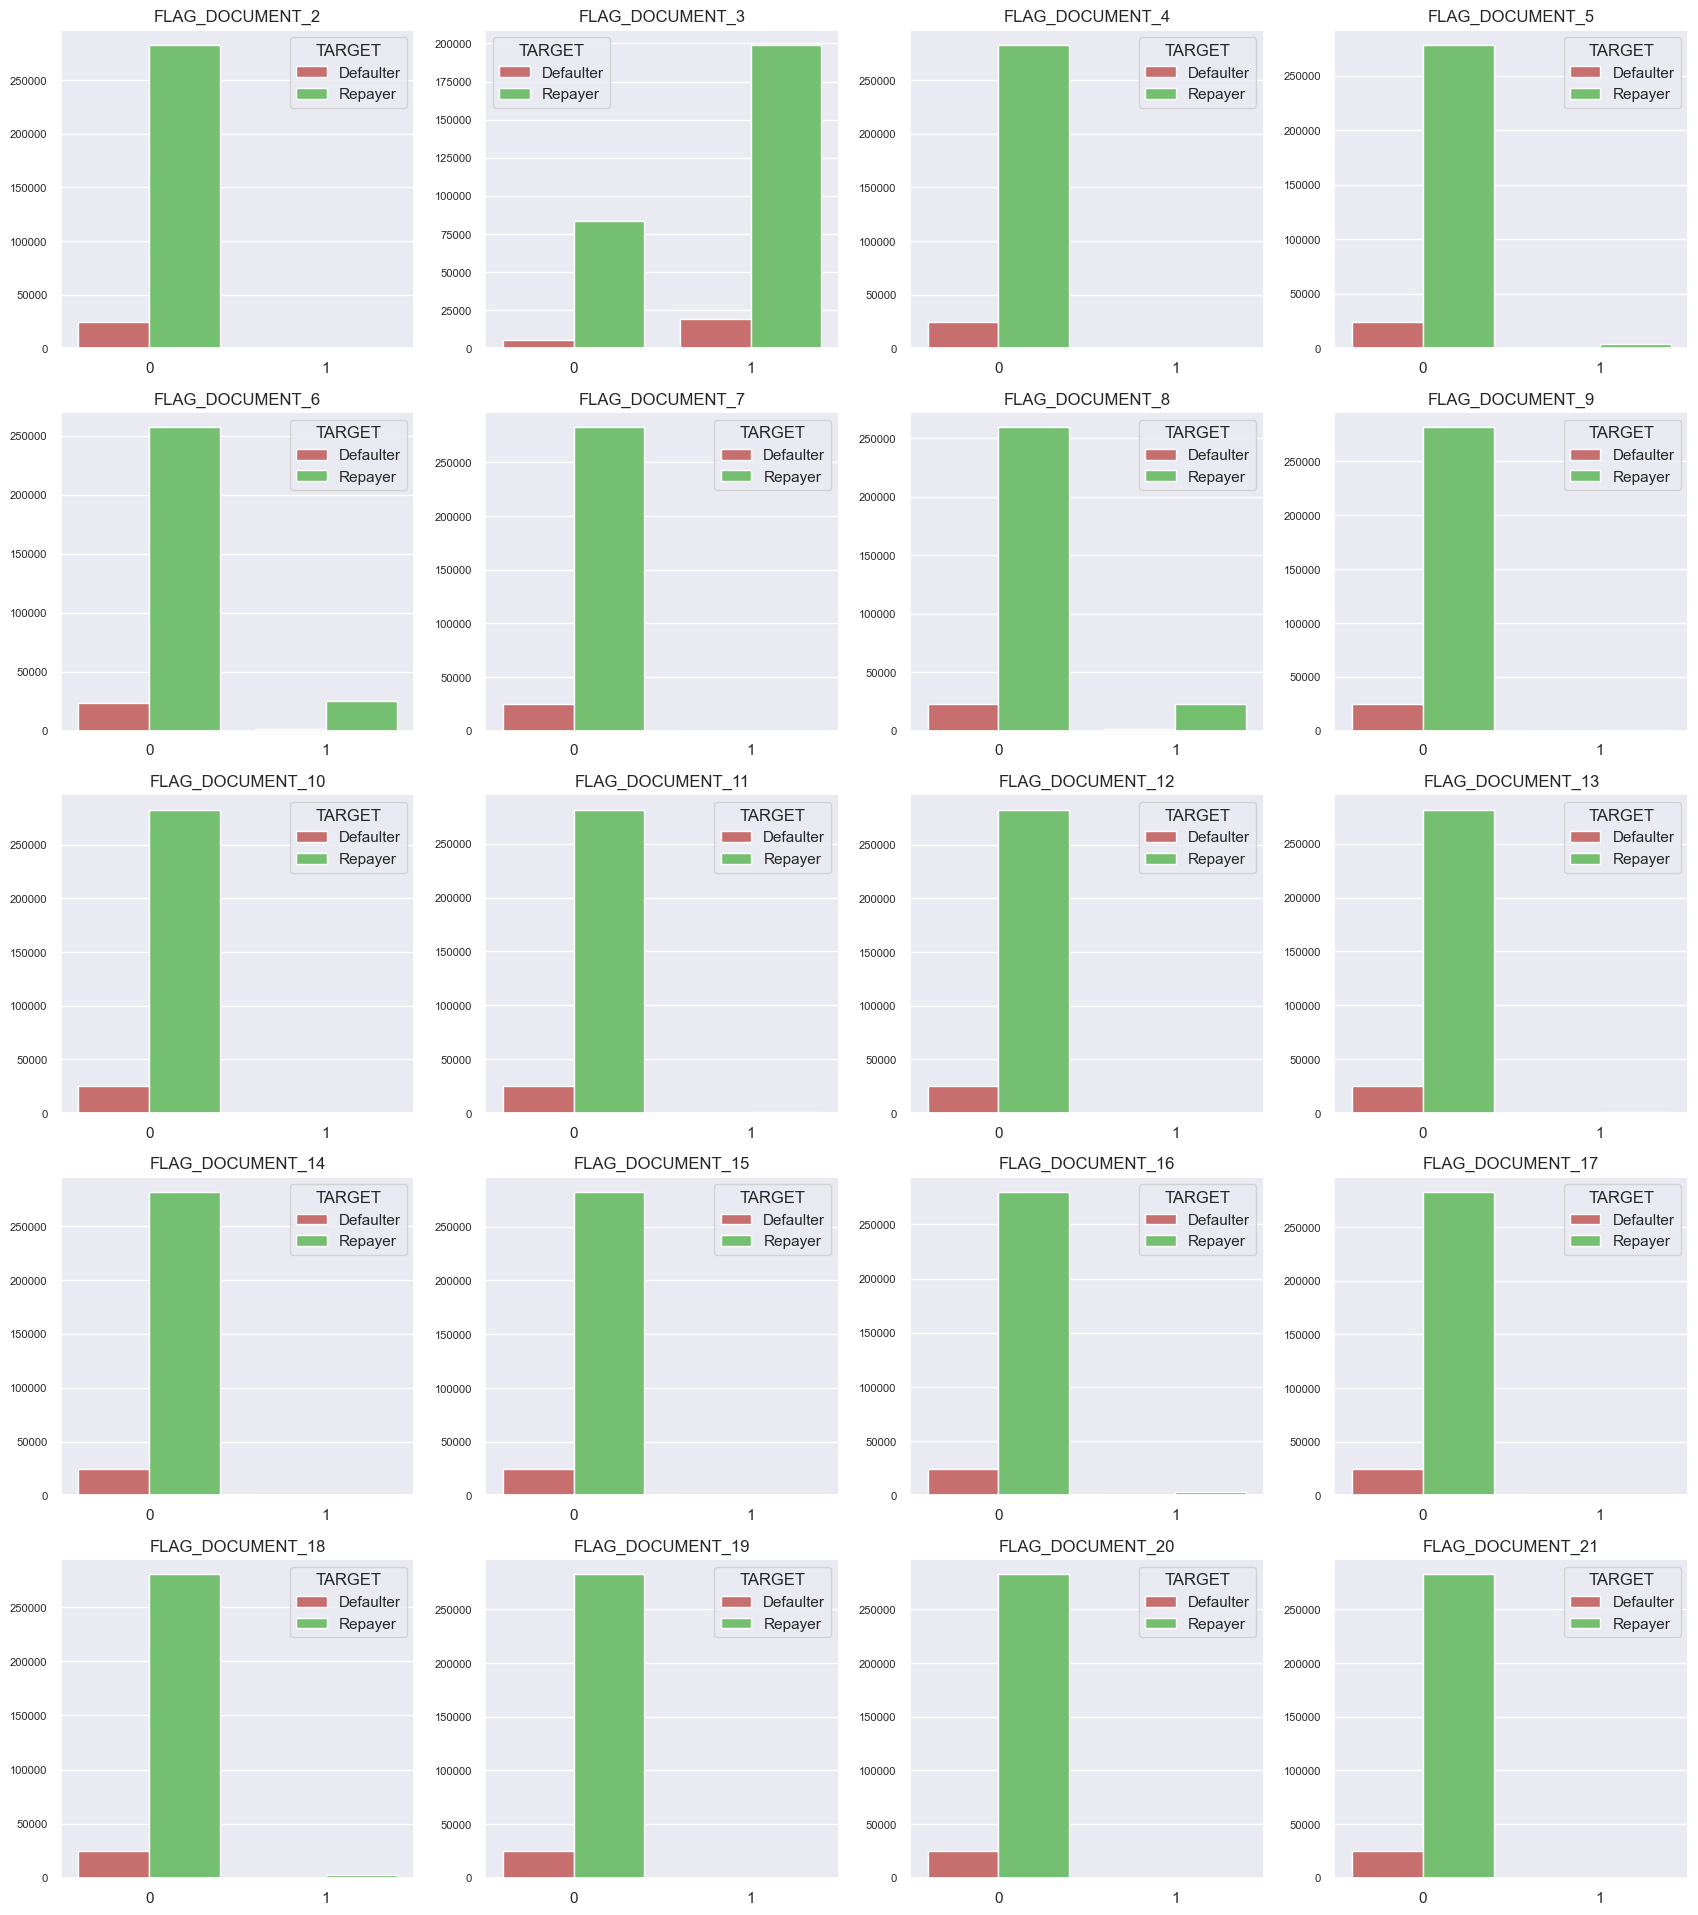

In [49]:
# Checking the relevance of Flag_Document and whether it has any relation with loan repayment status
document_columns = [
    "FLAG_DOCUMENT_2",
    "FLAG_DOCUMENT_3",
    "FLAG_DOCUMENT_4",
    "FLAG_DOCUMENT_5",
    "FLAG_DOCUMENT_6",
    "FLAG_DOCUMENT_7",
    "FLAG_DOCUMENT_8",
    "FLAG_DOCUMENT_9",
    "FLAG_DOCUMENT_10",
    "FLAG_DOCUMENT_11",
    "FLAG_DOCUMENT_12",
    "FLAG_DOCUMENT_13",
    "FLAG_DOCUMENT_14",
    "FLAG_DOCUMENT_15",
    "FLAG_DOCUMENT_16",
    "FLAG_DOCUMENT_17",
    "FLAG_DOCUMENT_18",
    "FLAG_DOCUMENT_19",
    "FLAG_DOCUMENT_20",
    "FLAG_DOCUMENT_21",
]
df_flag = df_app[document_columns + ["TARGET"]]

length = len(document_columns)

df_flag["TARGET"] = df_flag["TARGET"].replace({1: "Defaulter", 0: "Repayer"})

fig = plt.figure(figsize=(21, 24))

for i, j in itertools.zip_longest(document_columns, range(length)):
    plt.subplot(5, 4, j + 1)
    # ax = df_flag[i].value_counts.plot(kind="bar", stacked=True, color=["#d65f5f","#6acc64"])
    ax = sns.countplot(
        data=df_flag,
        x=i,
        hue=df_flag["TARGET"],
        palette=["#d65f5f","#6acc64"],
    )
    plt.yticks(fontsize=8)
    plt.xlabel("")
    plt.ylabel("")
    plt.title(i)

Only the Flag Document 3 have relevance. `Elaborate`

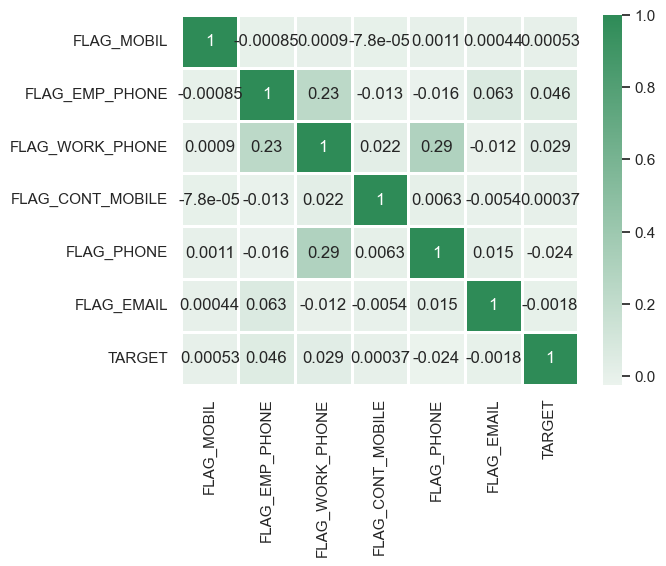

In [50]:
source_corr = df_app[
    [
        "FLAG_MOBIL",
        "FLAG_EMP_PHONE",
        "FLAG_WORK_PHONE",
        "FLAG_CONT_MOBILE",
        "FLAG_PHONE",
        "FLAG_EMAIL",
        "TARGET",
    ]
].corr()
ax = sns.heatmap(
    source_corr,
    xticklabels=source_corr.columns,
    yticklabels=source_corr.columns,
    annot=True,
    cmap=sns.light_palette("seagreen", as_cmap=True),
    linewidth=1,
)

Again no relevance with contacts.

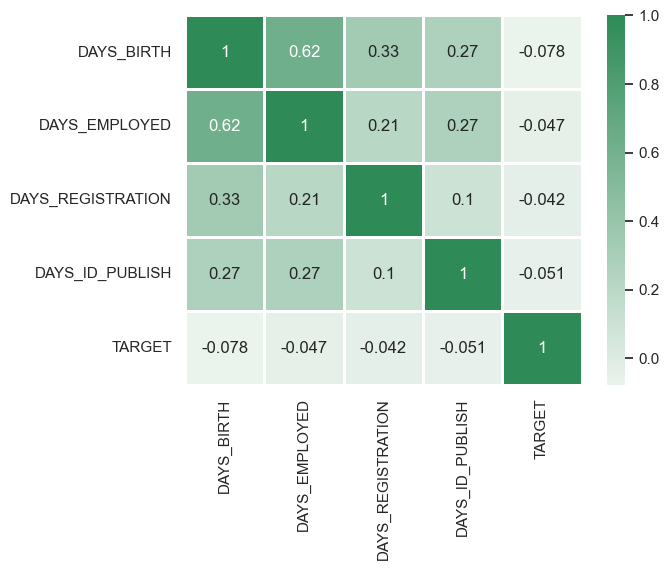

In [51]:
source_corr = df_app[
    ["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH", "TARGET"]
].corr()
ax = sns.heatmap(
    source_corr,
    xticklabels=source_corr.columns,
    yticklabels=source_corr.columns,
    annot=True,
    cmap=sns.light_palette("seagreen", as_cmap=True),
    linewidth=1,
)

Still there are little to no relevance for the days of birth, employment, registration, or ID publish.

#### We move to the previous dataset

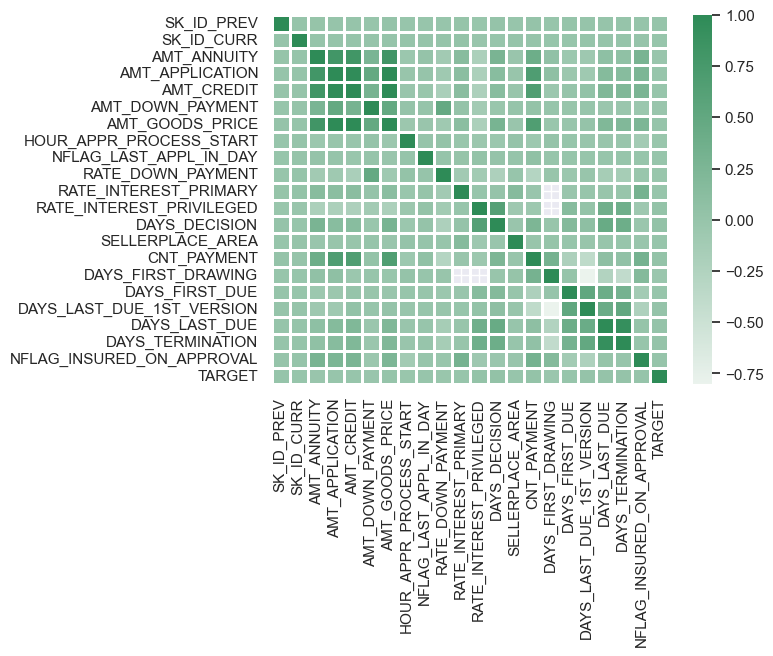

In [52]:
source_corr = df_previous.select_dtypes(include=np.number).corr()
ax = sns.heatmap(
    source_corr,
    xticklabels=source_corr.columns,
    yticklabels=source_corr.columns,
    cmap=sns.light_palette("seagreen", as_cmap=True),
    linewidth=1,)

We also get a small amount of relevance to the churn. This maybe because each transaction did not directly affect the churn. Take the sum of all amounts for each borrower and create a total amount history data.

In [53]:
df_history_total = df_previous[["AMT_ANNUITY", "AMT_APPLICATION", "AMT_CREDIT", "AMT_DOWN_PAYMENT", "AMT_GOODS_PRICE", "SK_ID_CURR"]].groupby("SK_ID_CURR").sum()
df_history_total.head()

,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE
SK_ID_CURR,,,,,
100001,3951.000,24835.5,23787.0,2520.0,24835.5
100002,9251.775,179055.0,179055.0,0.0,179055.0
100003,169661.970,1306309.5,1452573.0,6885.0,1306309.5
100004,5357.250,24282.0,20106.0,4860.0,24282.0
100005,4813.200,44617.5,40153.5,4464.0,44617.5


In [54]:
df_history_total = df_history_total.merge(target_id, how='left', on='SK_ID_CURR').fillna(0)


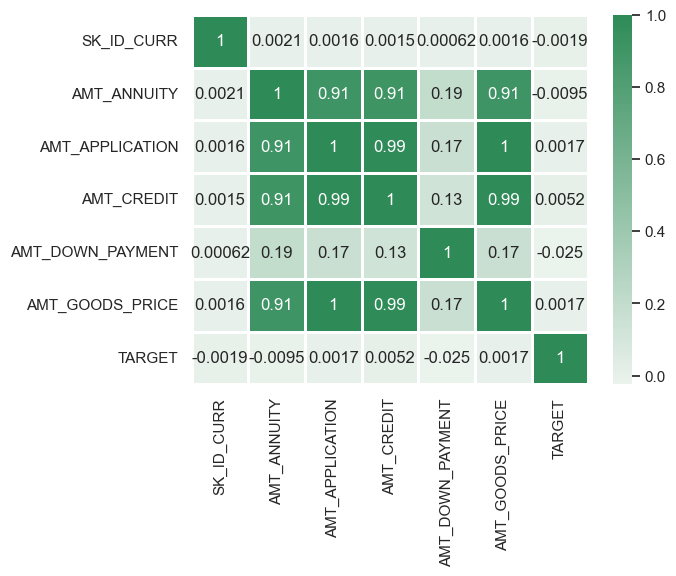

In [55]:
source_corr = df_history_total.select_dtypes(include=np.number).corr()
ax = sns.heatmap(
    source_corr,
    xticklabels=source_corr.columns,
    yticklabels=source_corr.columns,
    cmap=sns.light_palette("seagreen", as_cmap=True),
    annot=True,
    linewidth=1,)

Even with summed amount, the relation bertween historical amount to the target holds no relevance.

## Analysis

In [ ]:
"#6acc64"
"#d65f5f

Text(0.5, 1.0, 'Age Group')

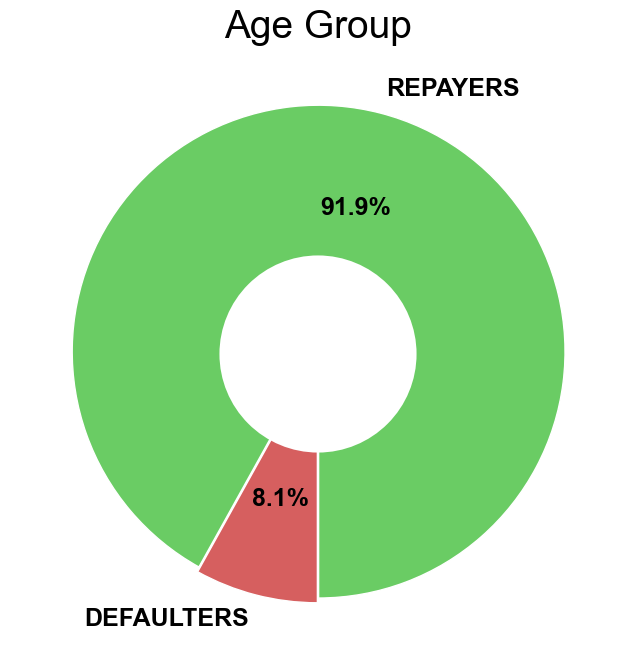

In [148]:
fig = plt.figure(figsize=(8, 8))
explode = [0.01, 0.01, 0.01, 0.4, 0.01, 0.01, 0.01, 0.01]

ax1, ax2, ax3 = plt.pie(
    df_app['TARGET'].value_counts().values,
    colors=["#6acc64","#d65f5f"],
    labels=["REPAYERS", "DEFAULTERS"],
    autopct="%1.1f%%",
    explode=explode[:2],
    wedgeprops={"edgecolor": "white", "linewidth": 1},
    startangle=270
)
for autotext in ax3:
    autotext.set_color("black")

for autotext in ax2:
    autotext.set_color("black")
plt.setp(ax3, size=18, weight="bold")
plt.setp(ax2, size=18, weight="bold")
centre_circle = plt.Circle(
    (0, 0),
    0.40,
    fc="white",
    linewidth=0,
)
fig = plt.gcf()

fig.gca().add_artist(centre_circle)

plt.title("Age Group", fontdict={"size": 28, "color": "Black"})

Check age range.

In [56]:
df_app

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AGE,EMPLOYED_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,9461,637,3648.0,2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,25,1
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,16765,1188,1186.0,291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,45,3
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,19046,225,4260.0,2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [57]:
bins = [0,17,30,45,65,100]
slots = ['Child','Young Adults','Adults','Seniors','Retired']

df_app['AGE_GROUP']=pd.cut(df_app['AGE'],bins=bins,labels=slots)

In [59]:
df_app['AGE_GROUP'].value_counts().sort_index()

AGE_GROUP
Child                0
Young Adults     52806
Adults          123114
Seniors         126582
Retired           5009
Name: count, dtype: int64

Many are borrowers adults or seniors.

In [60]:
df_app["EMPLOYED_YEAR"]

0            1
1            3
2            0
3            8
4            8
          ... 
307506       0
307507    1000
307508      21
307509      13
307510       3
Name: EMPLOYED_YEAR, Length: 307511, dtype: int64

In [61]:
# Creating bins for Employement Time
bins = [0,5,10,20,30,40,150]
slots = ['0-5','5-10','10-20','20-30','30-40','40 above']

df_app['EMPLOYMENT_YEAR']=pd.cut(df_app['EMPLOYED_YEAR'],bins=bins,labels=slots)

In [117]:
def stacked_plot(df, column,target, labels, percentage=False):
    
    df_func = df.copy()
    if percentage:
        print(df_func[column].value_counts(normalize=True)*100)

    target_1 = df_func[df_func[target] == 1].groupby(column).count()[df_func.columns[0]]
    target_0 = df_func[df_func[target] == 0].groupby(column).count()[df_func.columns[0]]

    df_graph = pd.concat([target_0, target_1], axis=1).reset_index()
    df_graph.columns = [column, labels[0], labels[1]]

    plt.bar(df_graph[column], df_graph[labels[0]], color="#6acc64")
    plt.bar(df_graph[column], df_graph[labels[1]], bottom=df_graph[labels[0]], color="#d65f5f")
    plt.xticks(rotation = 90)
    plt.show()

    

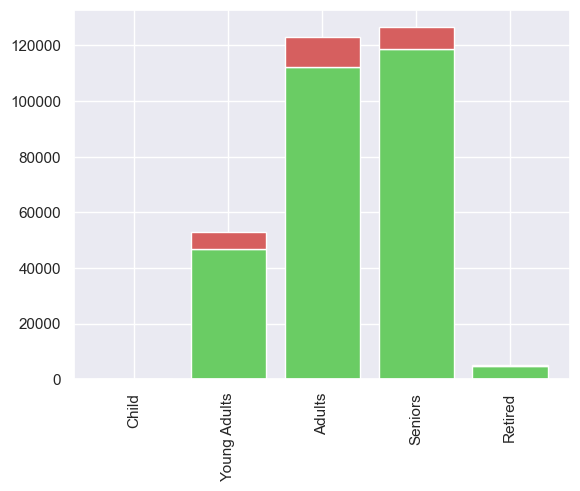

In [151]:
stacked_plot(
    df_app,
    "AGE_GROUP",
    "TARGET",
    labels=["REPAYER", "DEFAULTER"]
)

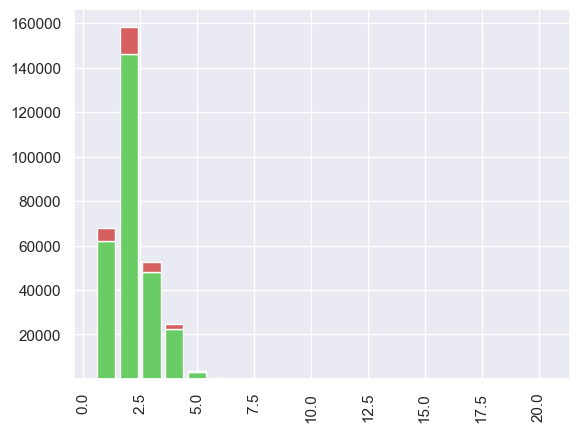

In [184]:
stacked_plot(df_app, "CNT_FAM_MEMBERS", "TARGET", labels=["REPAYER", "DEFAULTER"])

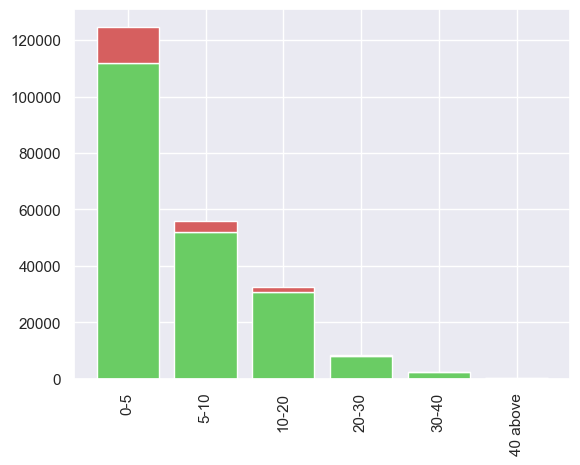

In [118]:
stacked_plot(
    df_app,
    "EMPLOYMENT_YEAR",
    "TARGET",
    labels=["REPAYER", "DEFAULTER"]
)

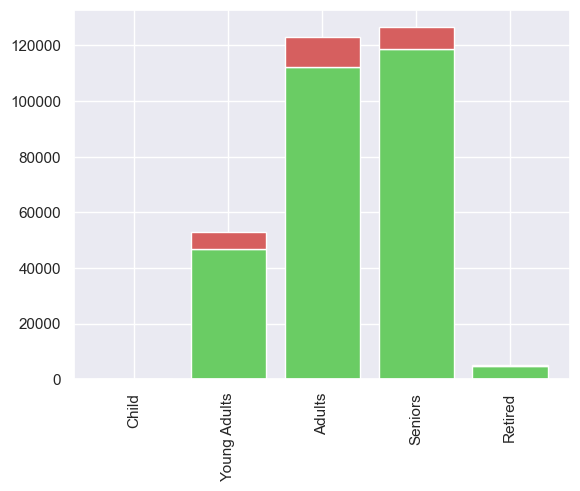

In [119]:
stacked_plot(df_app, "AGE_GROUP", "TARGET", labels=["REPAYER", "DEFAULTER"])

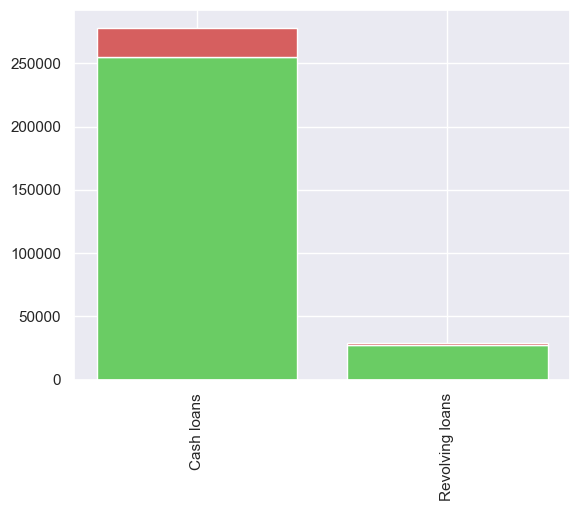

In [120]:
stacked_plot(df_app, "NAME_CONTRACT_TYPE", "TARGET", labels=["REPAYER", "DEFAULTER"])

In [121]:
# Creating bins for income amount
df_app['AMT_INCOME_RANGE']=df_app['AMT_INCOME_TOTAL']/100000

bins = [0,1,2,3,4,5,6,7,8,9,10,11]
slot = ['0-100K','100K-200K', '200k-300k','300k-400k','400k-500k','500k-600k','600k-700k','700k-800k','800k-900k','900k-1M', '1M Above']

df_app['AMT_INCOME_RANGE']=pd.cut(df_app['AMT_INCOME_RANGE'],bins,labels=slot)


df_app['AMT_CREDIT_RANGE']=df_app['AMT_CREDIT']/100000

bins = [0,1,2,3,4,5,6,7,8,9,10,100]
slots = ['0-100K','100K-200K', '200k-300k','300k-400k','400k-500k','500k-600k','600k-700k','700k-800k',
       '800k-900k','900k-1M', '1M Above']

df_app['AMT_CREDIT_RANGE']=pd.cut(df_app['AMT_CREDIT_RANGE'],bins=bins,labels=slots)


AMT_CREDIT_RANGE
200k-300k    17.824728
1M Above     16.254703
500k-600k    11.131960
400k-500k    10.418489
100K-200K     9.801275
300k-400k     8.564897
600k-700k     7.820533
800k-900k     7.086576
700k-800k     6.241403
900k-1M       2.902986
0-100K        1.952450
Name: proportion, dtype: float64


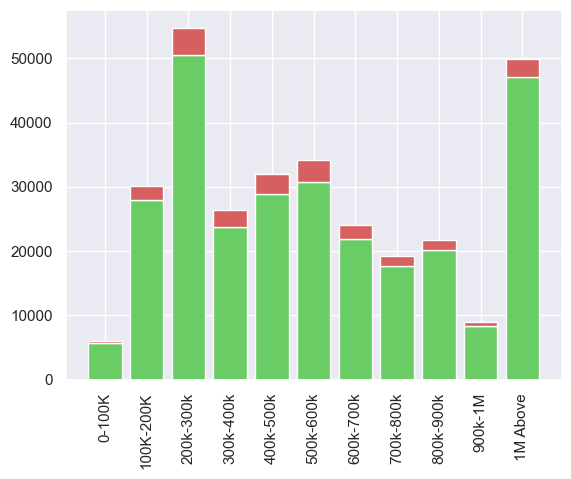

In [122]:
stacked_plot(df_app, "AMT_CREDIT_RANGE", "TARGET", labels=["REPAYER", "DEFAULTER"], percentage=True)

AMT_INCOME_RANGE
100K-200K    50.735000
200k-300k    21.210691
0-100K       20.729695
300k-400k     4.776116
400k-500k     1.744669
500k-600k     0.356354
600k-700k     0.282805
800k-900k     0.096980
700k-800k     0.052721
900k-1M       0.009112
1M Above      0.005858
Name: proportion, dtype: float64


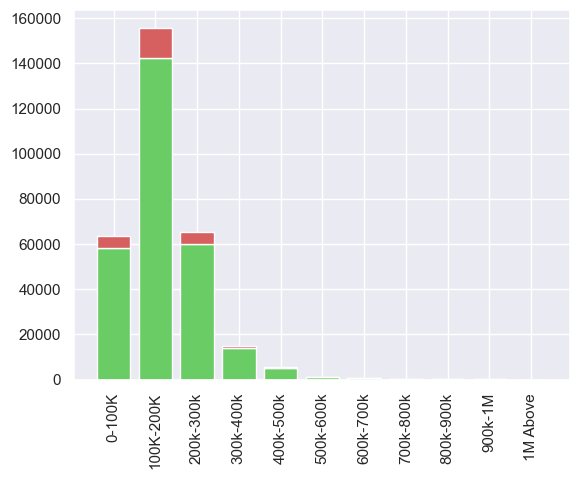

In [123]:
stacked_plot(df_app, "AMT_INCOME_RANGE", "TARGET", labels=["REPAYER", "DEFAULTER"], percentage=True)

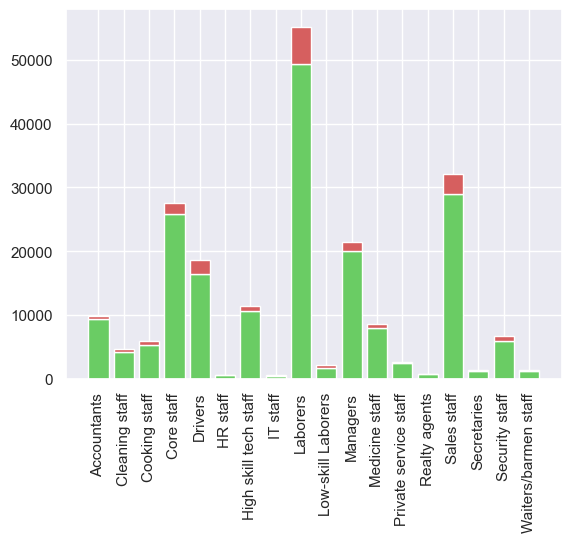

In [124]:
stacked_plot(df_app, "OCCUPATION_TYPE", "TARGET", labels=["REPAYER", "DEFAULTER"])

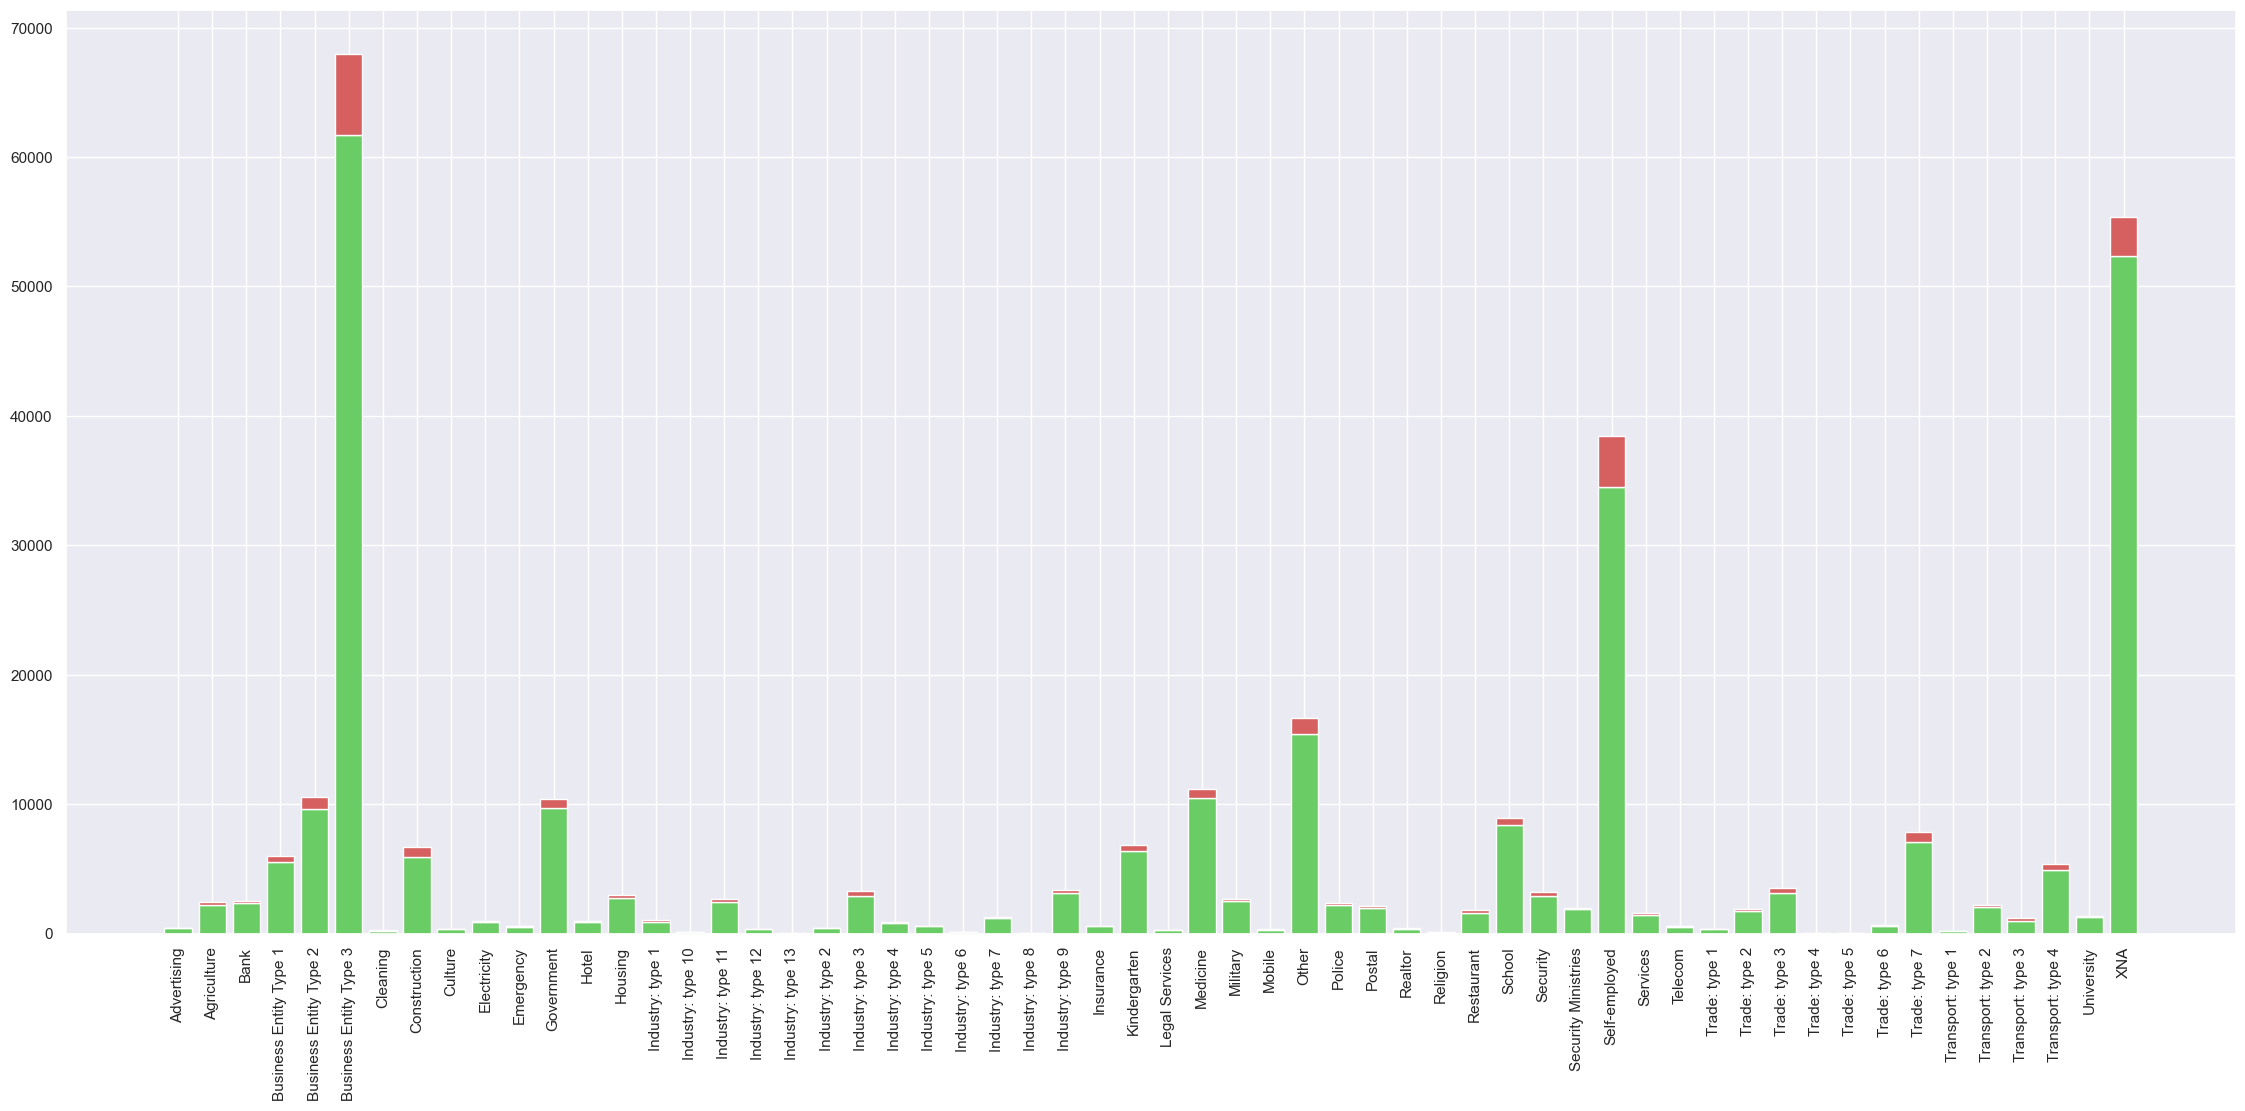

In [182]:
plt.figure(figsize=(28,12))
stacked_plot(df_app, "ORGANIZATION_TYPE", "TARGET", labels=["REPAYER", "DEFAULTER"])

## CHECK DISTRIBUTION

In [157]:
df_app.nunique().sort_values()

FLAG_EMP_PHONE                       2
FLAG_CONT_MOBILE                     2
FLAG_PHONE                           2
FLAG_EMAIL                           2
FLAG_DOCUMENT_9                      2
FLAG_DOCUMENT_10                     2
EMERGENCYSTATE_MODE                  2
FLAG_DOCUMENT_11                     2
REG_REGION_NOT_LIVE_REGION           2
REG_REGION_NOT_WORK_REGION           2
LIVE_REGION_NOT_WORK_REGION          2
REG_CITY_NOT_LIVE_CITY               2
REG_CITY_NOT_WORK_CITY               2
LIVE_CITY_NOT_WORK_CITY              2
FLAG_DOCUMENT_19                     2
FLAG_DOCUMENT_18                     2
FLAG_DOCUMENT_17                     2
FLAG_DOCUMENT_16                     2
FLAG_DOCUMENT_15                     2
FLAG_DOCUMENT_14                     2
FLAG_WORK_PHONE                      2
FLAG_DOCUMENT_13                     2
FLAG_DOCUMENT_12                     2
FLAG_DOCUMENT_20                     2
TARGET                               2
NAME_CONTRACT_TYPE       

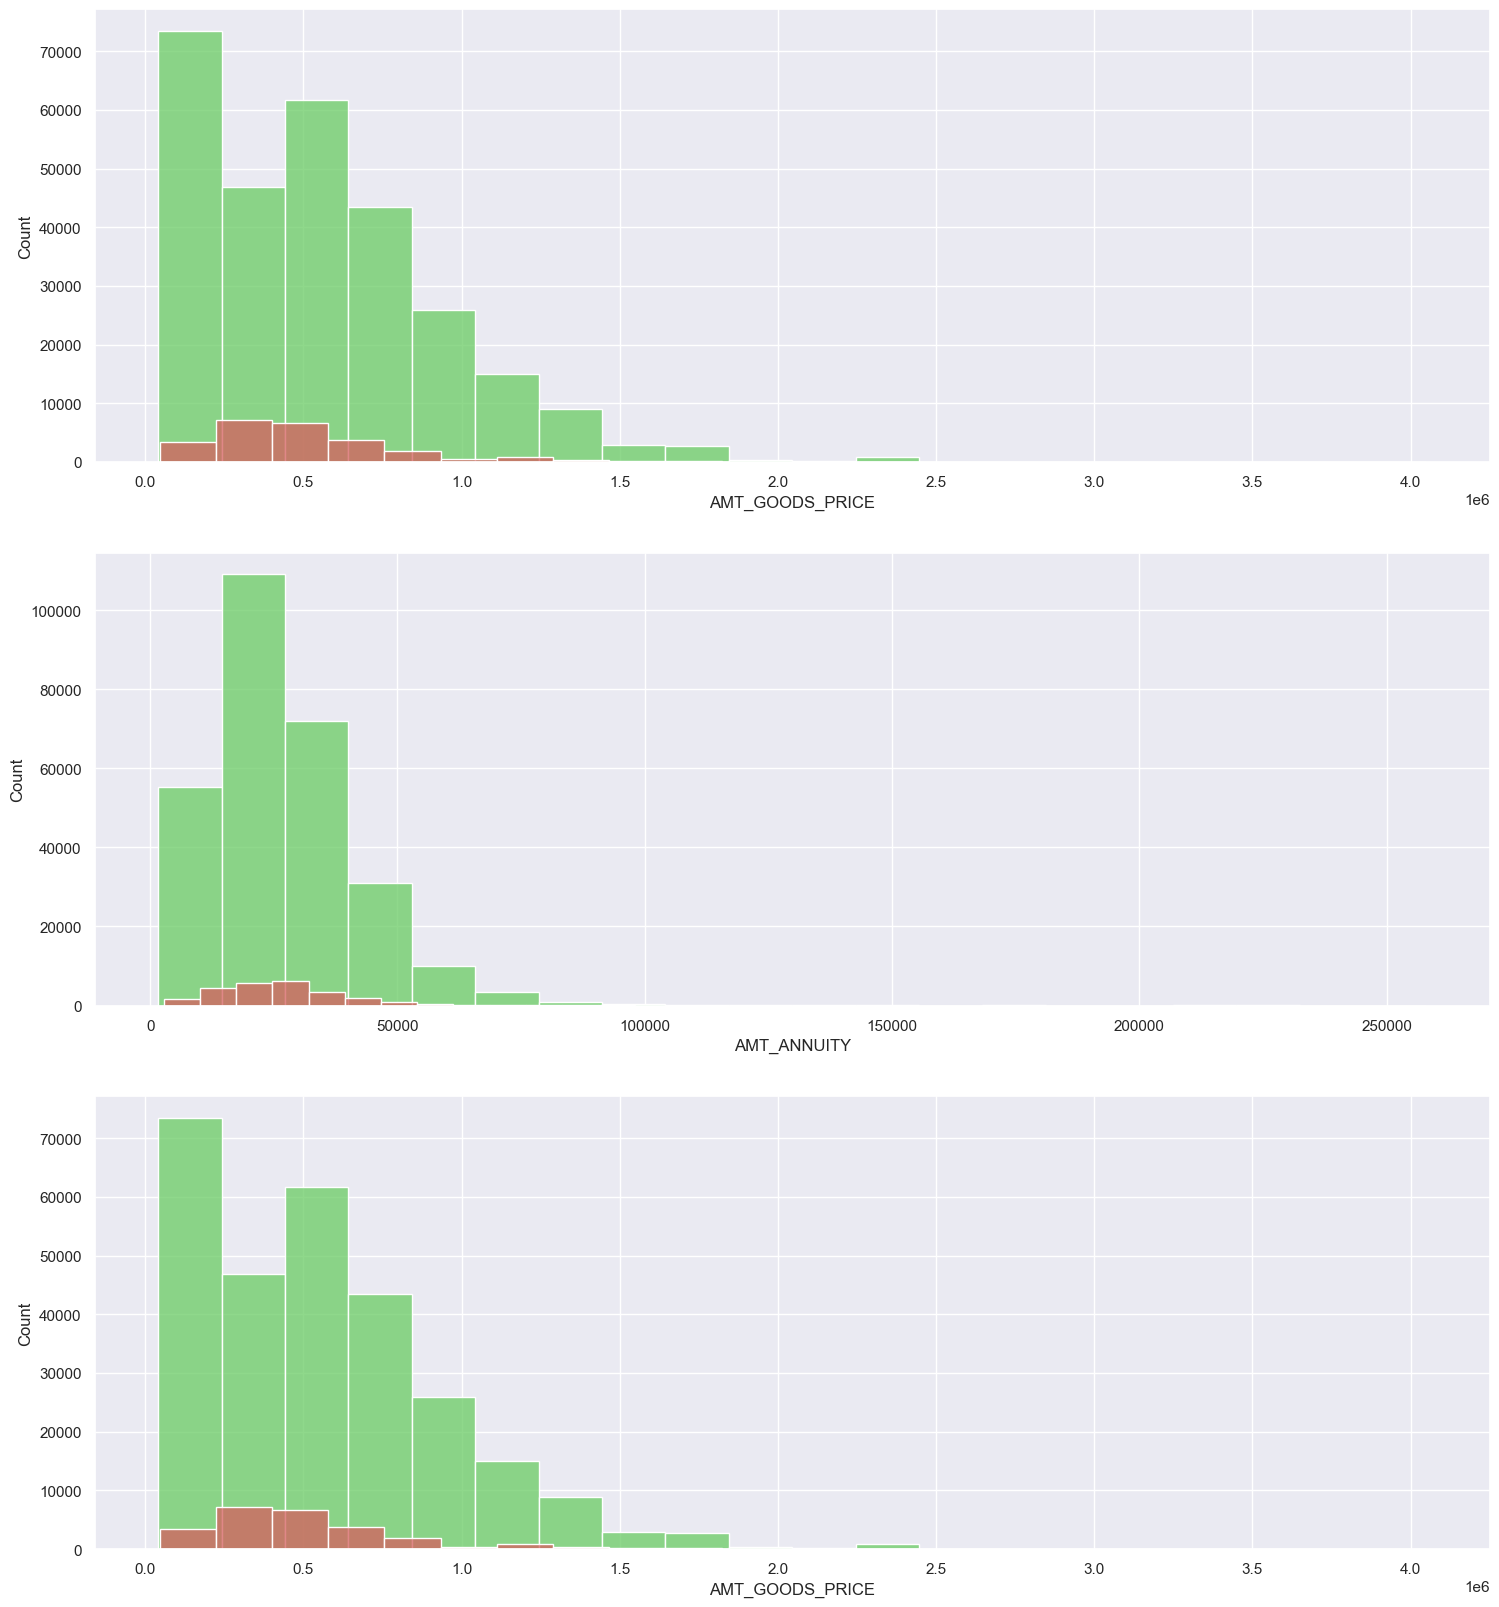

In [174]:
columns = ['AMT_GOODS_PRICE', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']

fig, axs = plt.subplots(nrows=len(columns), figsize=(18,20))

for i, j in enumerate(columns):
    sns.histplot(df_app[df_app["TARGET"] == 0][j], bins=20, ax=axs[i], color="#6acc64")
    sns.histplot(df_app[df_app["TARGET"] == 1][j], bins=20, ax=axs[i], color="#d65f5f")

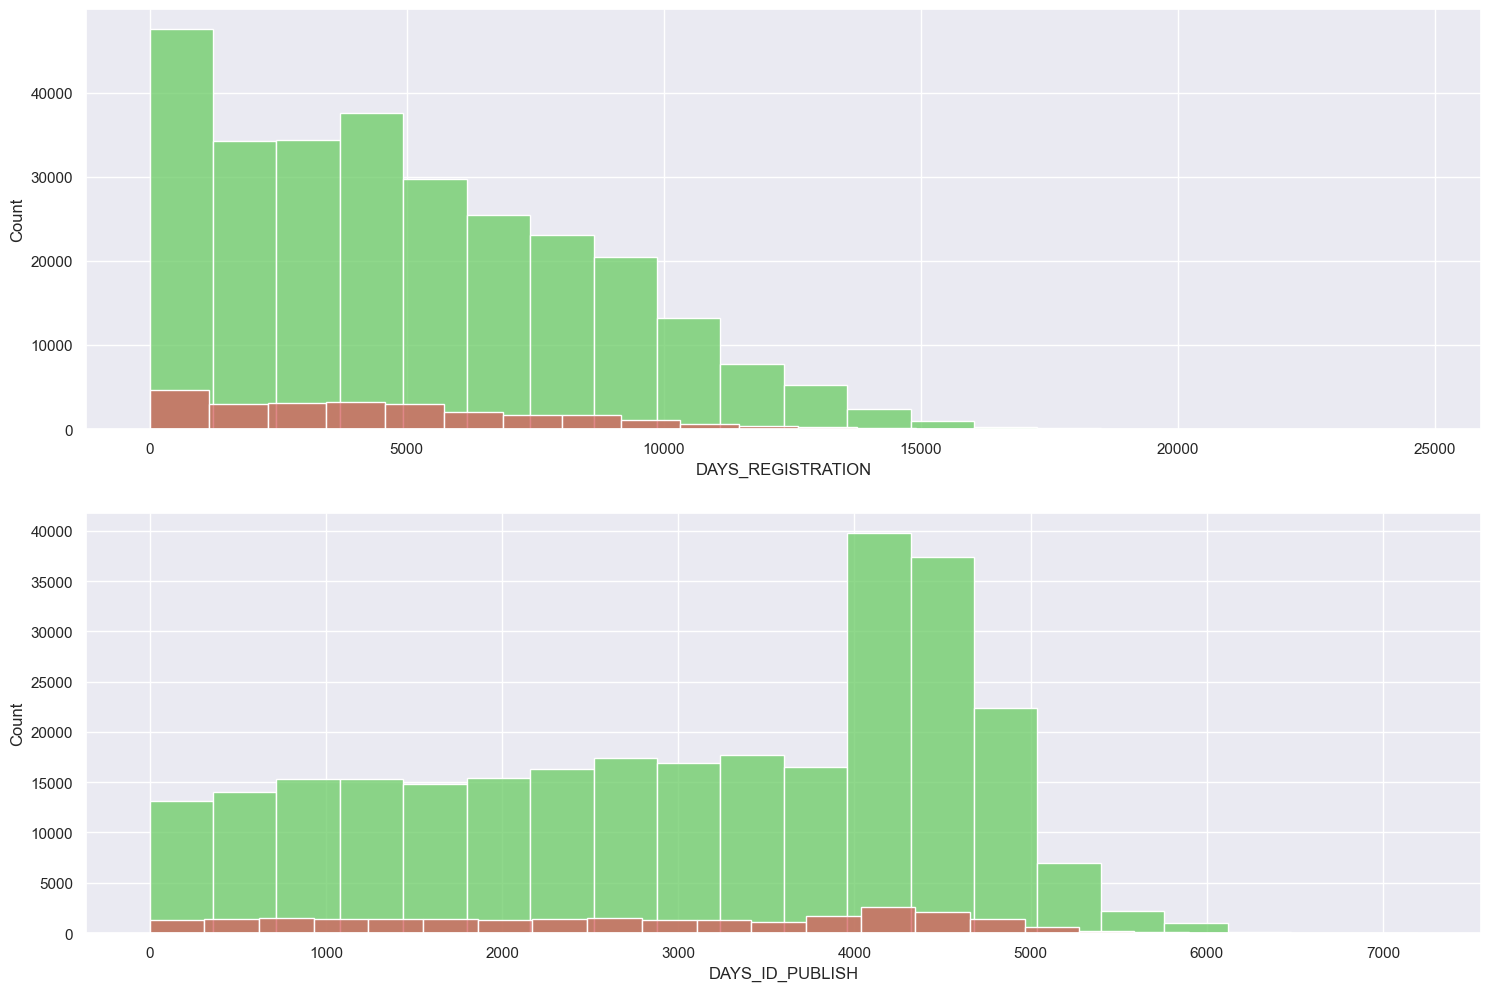

In [168]:
columns = ['DAYS_REGISTRATION', 'DAYS_ID_PUBLISH']

fig, axs = plt.subplots(nrows=len(columns), figsize=(18,6*len(columns)))

for i, j in enumerate(columns):
    sns.histplot(df_app[df_app["TARGET"] == 0][j], bins=20, ax=axs[i], color="#6acc64")
    sns.histplot(df_app[df_app["TARGET"] == 1][j], bins=20, ax=axs[i], color="#d65f5f")

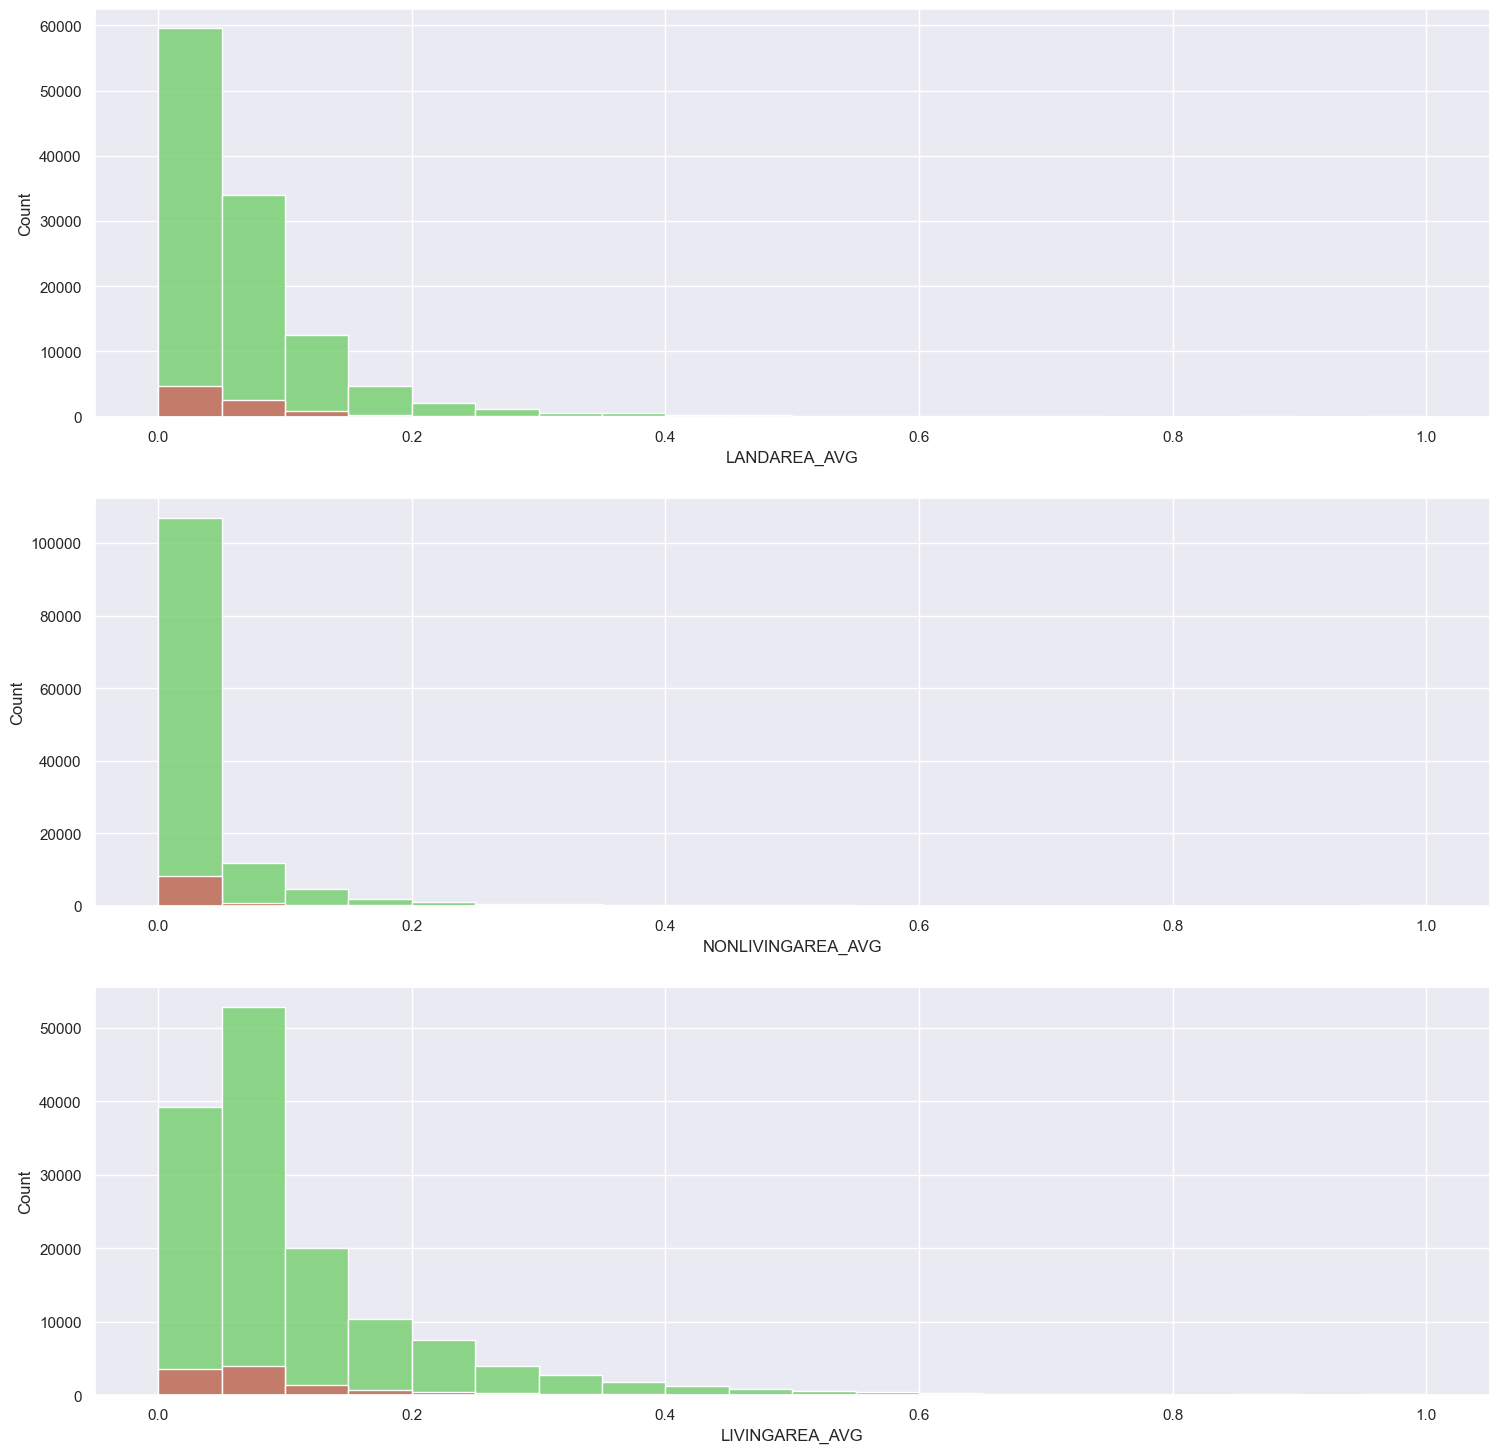

In [175]:
columns = ['LANDAREA_AVG', 'NONLIVINGAREA_AVG', 'LIVINGAREA_AVG']

fig, axs = plt.subplots(nrows=len(columns), figsize=(18,6*len(columns)))

for i, j in enumerate(columns):
    sns.histplot(df_app[df_app["TARGET"] == 0][j], bins=20, ax=axs[i], color="#6acc64")
    sns.histplot(df_app[df_app["TARGET"] == 1][j], bins=20, ax=axs[i], color="#d65f5f")

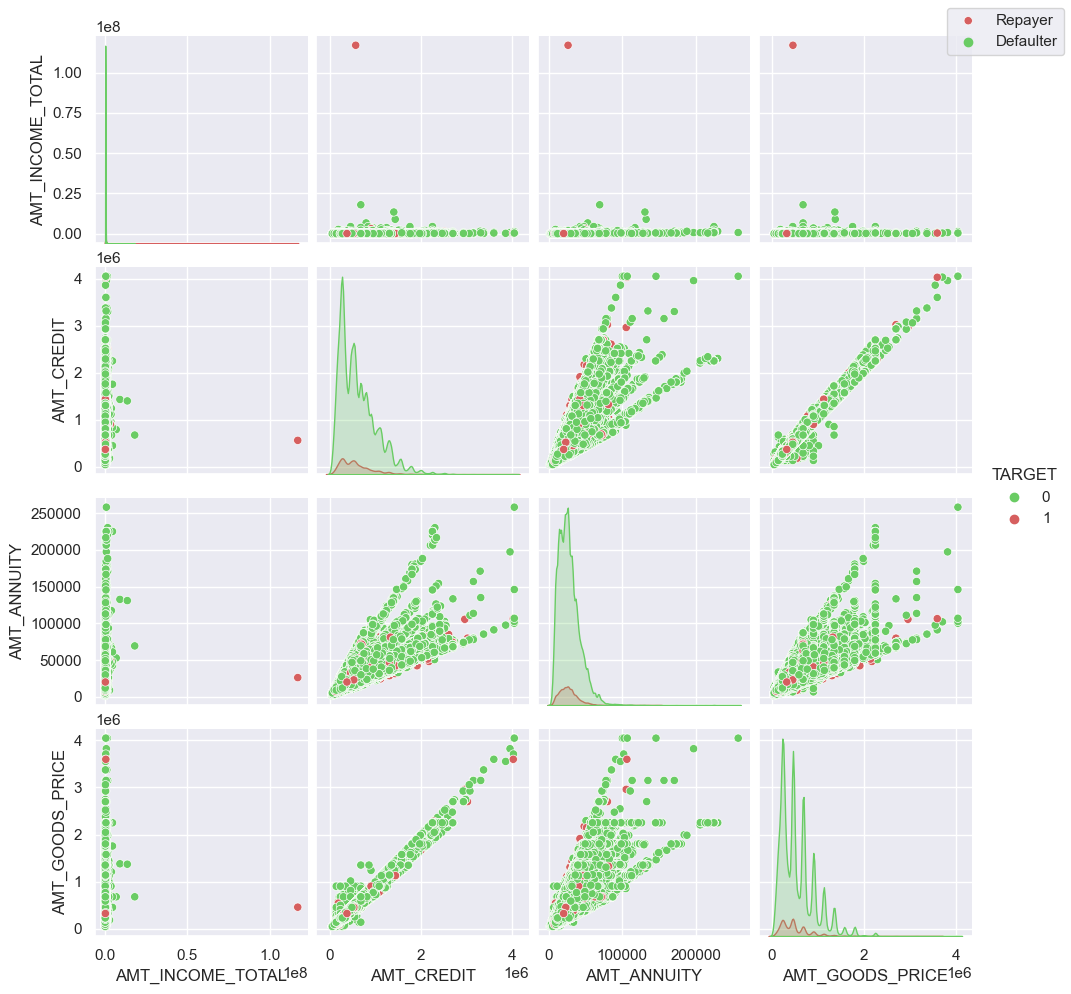

In [185]:
amount = df_app[[ 'AMT_INCOME_TOTAL','AMT_CREDIT',
                         'AMT_ANNUITY', 'AMT_GOODS_PRICE','TARGET']]
amount = amount[(amount["AMT_GOODS_PRICE"].notnull()) & (amount["AMT_ANNUITY"].notnull())]
ax= sns.pairplot(amount,hue="TARGET",palette=["#6acc64","#d65f5f"])
ax.fig.legend(labels=['Repayer','Defaulter'])
plt.show()

# FEATURE ENGINEERING

## Feature Splitting

In [213]:
X = df_app_raw.drop('TARGET', axis=1)
y = df_app_raw['TARGET']

In [214]:
# Bagi menjadi train, validasi, dan test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=17)

In [215]:
# Lihat ukuran tiap set
print('Train size: ', X_train.shape)
print('Val size: ', X_val.shape)
print('Test size: ', X_test.shape)

Train size:  (196806, 121)
Val size:  (49202, 121)
Test size:  (61503, 121)


In [216]:
app_cat_cols

array(['FLAG_DOCUMENT_4', 'NAME_CONTRACT_TYPE', 'FLAG_DOCUMENT_16',
       'FLAG_EMAIL', 'REGION_RATING_CLIENT_W_CITY', 'FLAG_DOCUMENT_13',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_21', 'NAME_INCOME_TYPE',
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_17',
       'REG_REGION_NOT_LIVE_REGION', 'WALLSMATERIAL_MODE',
       'REG_CITY_NOT_LIVE_CITY', 'FONDKAPREMONT_MODE', 'TARGET',
       'LIVE_CITY_NOT_WORK_CITY', 'CODE_GENDER', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_14', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'LIVE_REGION_NOT_WORK_REGION',
       'FLAG_DOCUMENT_7', 'REGION_RATING_CLIENT', 'FLAG_DOCUMENT_10',
       'NAME_EDUCATION_TYPE', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'NAME_FAMILY_STATUS',
       'WEEKDAY_APPR_PROCESS_START', 'FLAG_DOCUMENT_11',
       'OCCUPATION_TYPE', 'REG_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE',
       'FLAG_OWN_CAR', 'FLAG_MOBIL', 'FLAG_

In [217]:
app_num_cols = [x for x in X_train.columns.to_list() if x not in app_cat_cols]

In [218]:
len(app_cat_cols)

52

In [219]:
len(app_num_cols)

70

## Feature Missing Value

## Feature Selection

In [220]:
# Looping fitur numerik kontinu dengan mannwhitneyu test
correlated_cat_ft = []
for ft in app_num_cols:
    target_pay = X_train[y_train == 0][ft]
    target_default = X_train[y_train == 1][ft]

    # Lakukan t-test
    f_statistic, p_value = mannwhitneyu(target_pay, target_default)

    # Lihat p-valuenya
    if p_value < 0.05:
        # Gagal tolak null hypothesis 
        print(f"Ada korelasi signifikan antara '{ft}' dengan churn pelanggan.")
        correlated_cat_ft.append(ft)
    else:
        # Tolak null hypothesis 
        print(f"Tidak ada bukti korelasi signifikan '{ft}' dengan churn pelanggan.")

Tidak ada bukti korelasi signifikan 'SK_ID_CURR' dengan churn pelanggan.
Ada korelasi signifikan antara 'CNT_CHILDREN' dengan churn pelanggan.
Ada korelasi signifikan antara 'AMT_INCOME_TOTAL' dengan churn pelanggan.
Ada korelasi signifikan antara 'AMT_CREDIT' dengan churn pelanggan.
Tidak ada bukti korelasi signifikan 'AMT_ANNUITY' dengan churn pelanggan.
Tidak ada bukti korelasi signifikan 'AMT_GOODS_PRICE' dengan churn pelanggan.
Ada korelasi signifikan antara 'REGION_POPULATION_RELATIVE' dengan churn pelanggan.
Ada korelasi signifikan antara 'DAYS_BIRTH' dengan churn pelanggan.
Ada korelasi signifikan antara 'DAYS_EMPLOYED' dengan churn pelanggan.
Ada korelasi signifikan antara 'DAYS_REGISTRATION' dengan churn pelanggan.
Ada korelasi signifikan antara 'DAYS_ID_PUBLISH' dengan churn pelanggan.
Tidak ada bukti korelasi signifikan 'OWN_CAR_AGE' dengan churn pelanggan.
Tidak ada bukti korelasi signifikan 'CNT_FAM_MEMBERS' dengan churn pelanggan.
Ada korelasi signifikan antara 'HOUR_APP

In [221]:
correlated_cat_ft

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'HOUR_APPR_PROCESS_START',
 'DAYS_LAST_PHONE_CHANGE']

In [226]:
app_cat_cols = np.delete(app_cat_cols, np.argwhere(app_cat_cols=='TARGET'))

In [228]:
# Lakukan looping chi-square untuk tiap parameter kategori
correlated_num_ft = []
for ft in app_cat_cols:
    contingency_table = pd.crosstab(y_train, X_train[ft])

    # Lakukan chi-square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    # Lihat p-valuenya
    if p_value < 0.05: 
        # Gagal tolak null hypothesis 
        print(f"Ada korelasi signifikan antara '{ft}' dengan churn pelanggan.")
        correlated_num_ft.append(ft)
    else:
        # Tolak null hypothesis 
        print(f"Tidak ada bukti korelasi signifikan '{ft}' dengan churn pelanggan.")

Tidak ada bukti korelasi signifikan 'FLAG_DOCUMENT_4' dengan churn pelanggan.
Ada korelasi signifikan antara 'NAME_CONTRACT_TYPE' dengan churn pelanggan.
Ada korelasi signifikan antara 'FLAG_DOCUMENT_16' dengan churn pelanggan.
Tidak ada bukti korelasi signifikan 'FLAG_EMAIL' dengan churn pelanggan.
Ada korelasi signifikan antara 'REGION_RATING_CLIENT_W_CITY' dengan churn pelanggan.
Ada korelasi signifikan antara 'FLAG_DOCUMENT_13' dengan churn pelanggan.
Ada korelasi signifikan antara 'FLAG_DOCUMENT_6' dengan churn pelanggan.
Ada korelasi signifikan antara 'FLAG_DOCUMENT_21' dengan churn pelanggan.
Ada korelasi signifikan antara 'NAME_INCOME_TYPE' dengan churn pelanggan.
Ada korelasi signifikan antara 'FLAG_DOCUMENT_18' dengan churn pelanggan.
Ada korelasi signifikan antara 'FLAG_DOCUMENT_9' dengan churn pelanggan.
Tidak ada bukti korelasi signifikan 'FLAG_DOCUMENT_17' dengan churn pelanggan.
Ada korelasi signifikan antara 'REG_REGION_NOT_LIVE_REGION' dengan churn pelanggan.
Ada korel

In [229]:
correlated_num_ft

['NAME_CONTRACT_TYPE',
 'FLAG_DOCUMENT_16',
 'REGION_RATING_CLIENT_W_CITY',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_21',
 'NAME_INCOME_TYPE',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_9',
 'REG_REGION_NOT_LIVE_REGION',
 'WALLSMATERIAL_MODE',
 'REG_CITY_NOT_LIVE_CITY',
 'FONDKAPREMONT_MODE',
 'LIVE_CITY_NOT_WORK_CITY',
 'CODE_GENDER',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_14',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'REGION_RATING_CLIENT',
 'NAME_EDUCATION_TYPE',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'HOUSETYPE_MODE',
 'EMERGENCYSTATE_MODE',
 'NAME_FAMILY_STATUS',
 'OCCUPATION_TYPE',
 'REG_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'FLAG_OWN_CAR',
 'REG_REGION_NOT_WORK_REGION',
 'FLAG_DOCUMENT_2',
 'FLAG_EMP_PHONE',
 'NAME_HOUSING_TYPE',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_8']